## Using workload and SQL metrics to predict execution time

### Import the libraries and define functions that compute SQL metrics

In [12]:
from multiprocessing import Process, Queue
import glob
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import math as m
import numpy as np
%matplotlib inline
plt.style.use('ggplot')

def collect_sqlm(num1,num2,queue):
    for i in range (num1,num2):
        tablenames = []
        operand_size = 0
        index_size = 0
        log_os = 0
        log_is = 0
        regex =[]
        query = fdf.loc[i,('query')].upper()
        query = re.sub(r',\s+', ',', query)
        if re.search(r'\ASELECT|INSERT|DELETE',query):
            regex = re.findall(r'(?<=FROM|JOIN|INTO)\s+[\w.]+',query)
        if re.search(r'\AUPDATE',query):
            regex = re.findall(r'(?<=UPDATE)\s+[\w.]+',query)
        if re.search(r'\AMERGE',query):
            regex1 = re.findall(r'(?<=INTO)\s+[\w.]+',query)
            regex2 = re.findall(r'(?<=MERGE)\s+[\w.]+',query)
            regex = regex1+regex2
        for item in regex:
            for table in item.split(','):
                tablenames.append(table)
        for table in tablenames:
            tableschema = ''
            tablename = ''
            if len(table.split('.')) == 2:
                tableschema = table.split('.')[0]
                tablename = table.split('.')[1]
                try:
                    operand_size = operand_size + sizedf.loc[tableschema.strip(),tablename.strip()].object_size
                    
                except KeyError:
                    operand_size = 0
                try:
                    index_size = index_size + sizedf.loc[tableschema.strip(),tablename.strip()].index_size
                except KeyError:
                    index_size = 0
        num_operations = 0
        
        base_operation = 'SELECT|INSERT|DELETE|UPDATE|MERGE|VALUES'
        set_operation = 'JOIN|UNION'
        final_operation = 'ORDER BY| GROUP BY'
        regex = re.findall(base_operation,query)
        num_operations = num_operations+len(regex)
        regex = re.findall(set_operation,query)
        num_operations = num_operations+len(regex)
        regex = re.findall(final_operation,query)
        num_operations = num_operations+len(regex)
        
        num_filters = 0
        regex = re.findall(r'WHERE',query)
        num_filters = len(regex)
        regex = re.findall(r' AND | OR ',query)
        num_filters = num_filters + len(regex)
        
        objects_size_tuple = (i,operand_size/1024/1024,index_size/1024/1024,num_operations,num_filters)
        queue.put(objects_size_tuple)
    queue.put((-1,-1,-1,-1,-1))
    return

def read_queue(queue):
    global sizobj_list
    global num_procs
    count = 0
    while True:
            location , operand_size,index_size,num_operations,num_filters = queue.get()
            if (operand_size == -1):
                count = count + 1
                #print (count)
            else:
                sizeobj_list.append((location,operand_size,index_size,num_operations,num_filters))
            if (count == num_procs):
                print ("done")
                break
    return

### Read the raw data for SQL metrics, Workload Metrics and Object sizes

In [13]:
path = r'/data/developer/python'    
allFiles = glob.glob(path + "/SQL_Metrics*.csv")     
list_ = []
notvalues = []
for file_ in allFiles:
    regex = re.search('SQL_Metrics_([0-9]*-[0-9]*-[0-9]*)-([0-9]*)', file_)
    df = pd.read_csv(file_,sep = '@',names = ['stmt_hash','query','exec_time'],index_col=False)
    df['date'] = regex.group(1)
    df['hour'] = regex.group(2)
    df.exec_time = pd.to_numeric(df.exec_time,errors='coerce')
    df.hour = pd.to_numeric(df.hour,errors='coerce')
    list_.append(df)
fdf = pd.concat(list_,ignore_index=True)
fdf = fdf[fdf.exec_time > 0].reset_index().drop('index',axis=1)       



allFiles = glob.glob(path + "/size*.csv")     
list_ = []
for file_ in allFiles:
    regex = re.search('size*', file_)
    sizedf = pd.read_csv(file_,sep = '@',names = ['tableschema','tablename','object_size','index_size','lob_size'],index_col=False)
    sizedf = sizedf.set_index(['tableschema', 'tablename'])

plt.style.use('ggplot')



fields = ['time','lock_wait_time','total_section_sort_time','diaglog_write_wait_time','direct_read_time','direct_write_time','log_buffer_wait_time','log_disk_wait_time','pool_read_time','pool_write_time','prefetch_wait_time','total_act_time','total_act_wait_time','total_cpu_time','total_extended_latch_wait_time','span']
path = r'/data/developer/python'    
allFiles = glob.glob(path + "/workload_stats_*.csv")     
list_ = []
for file_ in allFiles:
    regex = re.search('workload_stats_([0-9]*-[0-9]*-[0-9]*)', file_)
    wldf = pd.read_csv(file_,sep = '@',names = fields,index_col=False)
    list_.append(wldf)
final_wldf = pd.concat(list_,ignore_index=True)
final_wldf['hour'] = 0
final_wldf['date'] = 0
for i in range (0,len(final_wldf)):
    regex = re.search('([0-9-]*)T([0-9]*)', final_wldf.loc[i,('time')])
    final_wldf.loc[i,('date')] = regex.group(1)
    final_wldf.loc[i,('hour')] = int(regex.group(2)) + 1 
    
final_wldf = final_wldf.set_index(['date', 'hour'])
final_wldf.drop('time',axis=1,inplace = True)
final_wldf.drop('span',axis=1,inplace = True)



### Create the data frame with all the predictors and the response variable

In [16]:
import time
queue = Queue()
num_procs = 8
sizeobj_list = []
pro_list = []
num_rows = len(fdf)
group_size = int(num_rows/num_procs)
for group_num in range(0,num_procs):
    num1 = group_num*(group_size)
    num2 = num1 + group_size - 1
    proc = Process(target=collect_sqlm, args=(num1,num2,queue))
    pro_list.append(proc)

start = time.time()
for p in pro_list:
    p.start()
    
read_queue(queue)

sizeobj_df = pd.DataFrame(sizeobj_list, columns=['location', 'operand_size','index_size','num_operations','num_filters']).set_index('location')

final_df_sqlm = fdf.merge(sizeobj_df, left_index = True, right_index=True, how='inner').reset_index().drop('index',axis = 1)

sqlm_df = final_df_sqlm[final_df_sqlm.operand_size != 0]

processtime = time.time() - start
print("Took {} seconds with 8 processes.".format(processtime))

sqlm_final_df = sqlm_df.groupby(['date','hour'])['operand_size','index_size','num_operations','num_filters','exec_time'].mean()

final_df = sqlm_final_df.merge(final_wldf, left_index = True, right_index=True, how='inner')
print(final_df.shape)

done
Took 100.95531702041626 seconds with 8 processes.


### Log transform of response variable

In [56]:
final_df['log_exec_time'] = 0
final_df['log_lock_wait_time'] = 0
for i in range (0,len(final_df)):
        final_df.iloc[i,final_df.columns.get_loc('log_exec_time')] = m.log10(final_df.iloc[i].exec_time)

### Linear regression 

In [58]:
import statsmodels.formula.api as smf

X = final_df[['total_cpu_time','operand_size','num_filters']]
#X = final_df [['operand_size','index_size']]
y = final_df['log_exec_time']

est = smf.OLS(y, X)

est = est.fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log_exec_time   R-squared:                       0.891
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     413.3
Date:                Wed, 27 Jul 2016   Prob (F-statistic):           1.46e-72
Time:                        15:03:23   Log-Likelihood:                -59.390
No. Observations:                 154   AIC:                             124.8
Df Residuals:                     151   BIC:                             133.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
total_cpu_time  1.465e-10   4.41e-11      3.323      0.001      5.94e-11  2.34e-10
operand_size      -0.3563      0.061     -5.824      0.000        -0.477    -0.235
num_filters        0.9139      0.075     12.174      0.000         0.766     1.062
==============================================================================
Omnibus:                      111.648   Durbin-Watson:                   2.131
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              716.474
Skew:                           2.759   Prob(JB):                    2.63e-156
Kurtosis:                      12.011   Cond. No.                     4.15e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.15e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

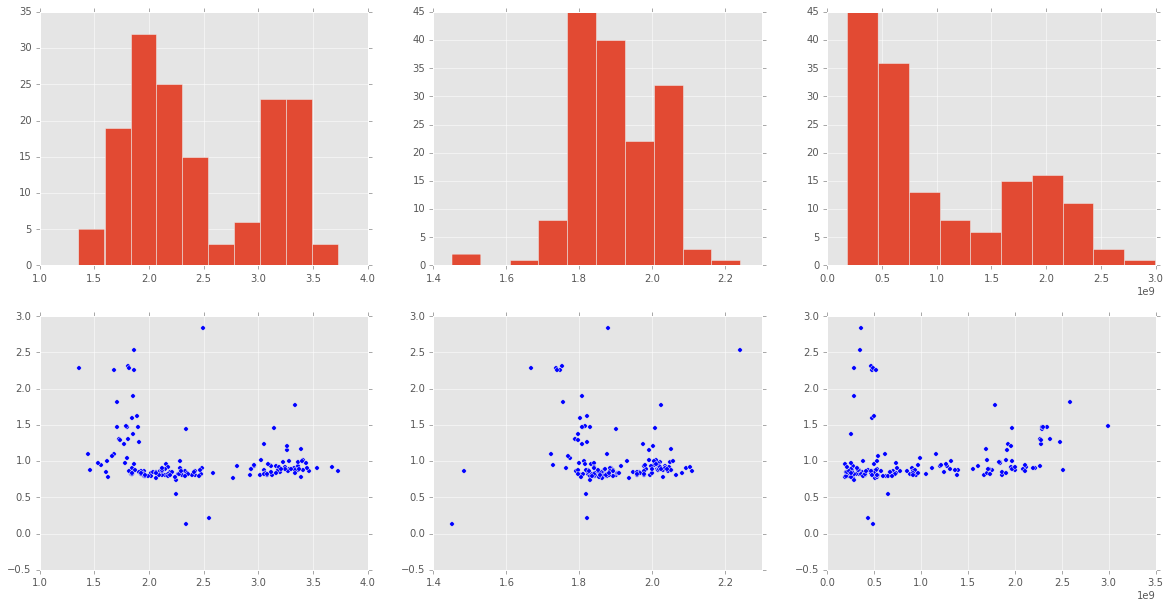

In [60]:
fig,axes = plt.subplots(2,3,figsize=(20,10))
axes[0][0].hist(final_df.operand_size)
axes[0][1].hist(final_df.num_filters)
axes[0][2].hist(final_df.total_cpu_time)
axes[1][0].scatter(final_df.operand_size,final_df.log_exec_time)
axes[1][1].scatter(final_df.num_filters,final_df.log_exec_time)
axes[1][2].scatter(final_df.total_cpu_time,final_df.log_exec_time)